In [1]:
!pip install tensorflow==2.13

In [2]:
# https://www.kaggle.com/datasets/sshikamaru/glaucoma-detection/code

import tensorflow as tf
import matplotlib.pyplot as plt
import keras
import numpy as np
import os
import pandas as pd
from keras.layers import Dense, GlobalAveragePooling2D, BatchNormalization, Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [3]:
from google.colab import drive
drive.mount('/content/drive')
print(tf.__version__)

Mounted at /content/drive
2.13.0


# Parámetros

In [8]:
from tensorflow.keras.applications import DenseNet201

In [9]:
folder = '/content/drive/MyDrive/glaucoma'

name = 'DenseNet201_0'
group = 'data/oringa/original'
url_save_model = f"{folder}/data/oringa/models/{name}_original.h5"

fc_layers = [1024, 512, 256, 128]
num_layers = len(fc_layers)
dropout = 0.3
steps_per_epoch = 30
epochs = 50
learning_rate = 1e-4
patience = 15


model = DenseNet201(input_shape=(224,224,3), weights='imagenet', include_top=False)
model.trainable = False

74836368/74836368 [==============================] - 0s 0us/step


# Cargar imagenes

In [10]:
train_dataset = keras.preprocessing.image_dataset_from_directory(
    directory = f'{folder}/{group}/Train/',
    labels = 'inferred', #Los labels son generados tomando en cuenta la estructura del directorio
    label_mode = 'categorical', #Los labels los entregara de la forma = [[1], [0], [1],...] para una loss binary_crossentropy
    class_names = ['negative', 'positive'], #Solo valido cuando se tiene inferred. lista de nombre de las clases
    color_mode = 'rgb', #Default 'rgb' convertira las imagenes en 1, 3 o 4 canales (grayscale, rgb, rgba)
    batch_size = 32, # Default 32. None entrega el dataset con muestras individuales
    image_size = (224,224), #Default (256,256). redimensiona las imagenes despues de leerlas en disco. (altura, ancho)
    shuffle = True, #Default True. mezcla la data aleatoriamente
    seed = 42, #optional. establecer semilla para mezclar y aplicar transformaciones
    validation_split = 0.2, #optional. flotante entre 0 y 1 para reservar parte de la data para validacion
    subset = 'training', #subconjunto de la data que retorna. 'training', 'validation', 'both'(retorna tupla con 2 datasets).
    interpolation = 'bilinear', # Default bilinear. metodo para aplicar resize("bilinear", "nearest", "bicubic", "area", "lanczos3", "lanczos5", "gaussian", "mitchellcubic")
    )


valid_dataset = keras.preprocessing.image_dataset_from_directory(
    directory=f'{folder}/{group}/Train/',
    labels="inferred",
    label_mode="categorical",
    class_names=['negative', 'positive'],
    color_mode='rgb',
    batch_size=32,
    image_size=(224, 224),
    shuffle=True,
    seed=42,
    validation_split=0.2,
    subset="validation",
    interpolation = 'bilinear'
)

test_dataset = keras.preprocessing.image_dataset_from_directory(
    directory=f'{folder}/{group}/Test/',
    labels="inferred",
    label_mode="categorical",
    class_names=['negative', 'positive'],
    color_mode='rgb',
    batch_size=32,
    image_size=(224, 224),
    shuffle=True,
    seed=42,
    interpolation = 'bilinear'
)

# Normalizamos

normalization_layer = tf.keras.layers.Rescaling(1./255)

train_dataset = train_dataset.map(lambda x, y: (normalization_layer(x), y))
valid_dataset = valid_dataset.map(lambda x, y: (normalization_layer(x), y))
test_dataset = test_dataset.map(lambda x, y: (normalization_layer(x), y))


Found 268 files belonging to 2 classes.
Using 215 files for training.
Found 268 files belonging to 2 classes.
Using 53 files for validation.
Found 68 files belonging to 2 classes.


# Modelo

In [ ]:
feature_map = model.output
x = GlobalAveragePooling2D()(feature_map)

# add Dense Layers
for idx in range(num_layers):
    neurons = fc_layers[idx]
    x = Dense(neurons, activation='relu')(x)

    if idx == num_layers-1:
        x = BatchNormalization()(x)
    else:
        x = Dropout(dropout)(x)

#Ouput layer
output = Dense(2, activation='softmax')(x)

model = keras.Model(inputs = model.input, outputs = output, name=name)

model.compile(loss="categorical_crossentropy",
                  optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
                  metrics=['accuracy'])

# TRAINING
print(f"\n===================\nTraining {name}")
"""
filepath = f"{folder}/data/oringa/checkpoints/{name}.weights.h5"

checkpoint = ModelCheckpoint(
    filepath,
    monitor = ["acc"],
    verbose= 1,
    mode = "max",
    save_weights_only=True
    )
"""

early_stopping = EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)


history = model.fit(
    train_dataset.repeat(),
    validation_data = (valid_dataset),
    epochs = epochs,
    steps_per_epoch = steps_per_epoch,
    shuffle = True,
    callbacks=[early_stopping]
)

model.save(url_save_model)

print(f"{name} Training finished!")


Training DenseNet201_0
Epoch 1/50
30/30 [==============================] - 233s 7s/step - loss: 0.9830 - accuracy: 0.5216 - val_loss: 0.6531 - val_accuracy: 0.7170
Epoch 2/50
30/30 [==============================] - 222s 7s/step - loss: 0.8216 - accuracy: 0.5855 - val_loss: 0.7278 - val_accuracy: 0.4717
Epoch 3/50
30/30 [==============================] - 209s 7s/step - loss: 0.7784 - accuracy: 0.6115 - val_loss: 0.6480 - val_accuracy: 0.5472
Epoch 4/50
30/30 [==============================] - 223s 7s/step - loss: 0.7659 - accuracy: 0.6175 - val_loss: 0.5802 - val_accuracy: 0.7925
Epoch 5/50
30/30 [==============================] - 222s 7s/step - loss: 0.6913 - accuracy: 0.6515 - val_loss: 0.5643 - val_accuracy: 0.7358
Epoch 6/50
30/30 [==============================] - 212s 7s/step - loss: 0.6636 - accuracy: 0.6602 - val_loss: 0.5751 - val_accuracy: 0.6981
Epoch 7/50
30/30 [==============================] - 213s 7s/step - loss: 0.6349 - accuracy: 0.6852 - val_loss: 0.5453 - val_accura

# Grafiquemos métricas

=== ResNet152V2_2 ===


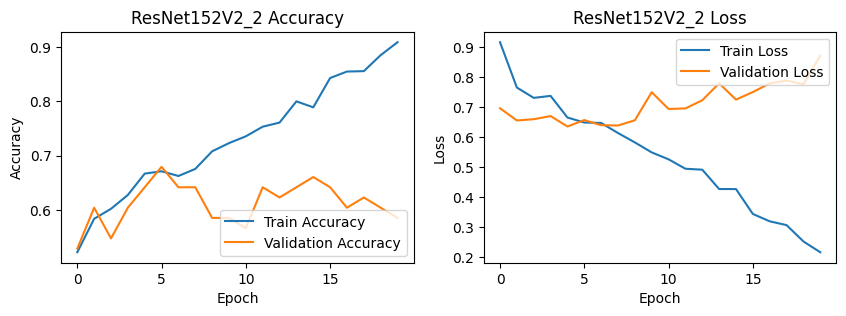

In [ ]:
def plot_history(history, model_name):
    # Resumir la historia de la precisión
    print(f'=== {model_name} ===')
    plt.figure(figsize=(10, 3))

    # Gráfico de la precisión (accuracy)
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{model_name} Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')

    # Gráfico de la pérdida (loss)
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{model_name} Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')

    plt.show()


plot_history(history, name)

# Predicciones

In [ ]:
dummy_predictions = []
dummy_y_true = []

for batch, labels in test_dataset:
    dummy_predictions.append(model.predict(batch, verbose=0))
    dummy_y_true.append(labels.numpy())

last_labels = dummy_y_true.pop()
last_predictions = dummy_predictions.pop()

predictions = np.array(dummy_predictions).reshape(-1,2)
y_true = np.array(dummy_y_true).reshape(-1,2)

predictions = np.concatenate((predictions, last_predictions), axis=0)
y_true = np.concatenate((y_true, last_labels), axis=0)

y_pred = np.argmax(predictions, axis=1)
y_true_le = np.argmax(y_true, axis=1)

#np.save(f'{folder}/origa/predictions/{name}_predictions_.npy', predictions)
#np.save(f'{folder}/origa/predictions/{name}_true_labels.npy', y_true)

# Metricas

In [ ]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

test_acc_values = accuracy_score(y_true_le, y_pred)
test_recall = recall_score(y_true_le, y_pred)
test_precision = precision_score(y_true_le, y_pred)
test_f1 = f1_score(y_true_le, y_pred)

acc_values = history.history['accuracy'][-1]
val_acc_values = history.history['val_accuracy'][-1]
loss_values = history.history['loss'][-1]
val_loss_values = history.history['val_loss'][-1]

print(f'Accuracy: {acc_values:.6f}')
print(f'Validation Accuracy: {val_acc_values:.6f}')
print(f'Test Accuracy: {test_acc_values:.6f}\n')
print(f'Recall: {test_recall:.6f}')
print(f'Precision: {test_precision:.6f}')
print(f'f1_score: {test_f1:.6f}\n')
print(f'Loss: {loss_values:.6f}')
print(f'Validamtion Loss: {val_loss_values:.6f}')

Accuracy: 0.909091
Validation Accuracy: 0.584906
Test Accuracy: 0.602941

Recall: 0.794118
Precision: 0.574468
f1_score: 0.666667

Loss: 0.216836
Validamtion Loss: 0.870417


In [ ]:
f'{folder}/{group}/Train/'

'/content/drive/MyDrive/Glaucoma/data/oringa/original/Train/'